# Self-Improving RAG Agent

## Overview

Traditional RAG systems have a critical limitation: they retrieve documents once and then generate an answer based on those documents, regardless of their relevance. An agentic approach allows the system to adapt its retrieval strategy based on objective performance metrics.

This notebook provides a framework for evaluating agentic RAG systems.

## Setup

First, let's install the necessary libraries:

In [2]:
%pip install openai chromadb sentence_transformers pandas matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [8]:
import openai
import chromadb
from chromadb.utils import embedding_functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import getpass
from tqdm import tqdm
from sentence_transformers import CrossEncoder
from typing import Optional, List, Dict, Type, Any

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define paths
DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

# Initialize OpenAI and Chroma
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
chroma_client = chromadb.PersistentClient()

# Global variables
K_VALUES = [1, 3, 5, 10]

### Loading Evaluation Dataset

Let's load the eval set we created previously:

In [4]:
eval_df = pd.read_json('../data/evalset/evalset.json')
print(f"Loaded {len(eval_df)} evaluation examples")
print(eval_df.head())

Loaded 209 evaluation examples
                  id                                                                                             document                                                                                                query                                                                                               answer
0  gpt_1.pdf_chunk_0  Improving Language Understanding\nby Generative Pre-Training\nAlec Radford\nOpenAI\nalec@openai....  describe the process of generative pre-training and its impact on language understanding tasks i...  The process of generative pre-training involves training a language model on a diverse corpus of...
1  gpt_1.pdf_chunk_1  speciﬁc task. In contrast to previous approaches, we make use of task-aware input\ntransformatio...                           key findings and performance metrics on evaluated benchmarks in this paper  The key findings indicate that the approach significantly improves upon the state of the art in .

### Let's build our Agent

In [5]:
class RAGAgent:
    def __init__(self, collection, llm_model: str = "gpt-3.5-turbo", embedding_model: str = "text-embedding-3-small", reranker_model: Optional[str] = None):
        self.collection = collection
        self.llm_model = llm_model
        self.embedding_model = embedding_model
        self.reranker_model = reranker_model
        self.max_iterations = 3
        self.target_metrics = {"recall": 0.8, "mrr": 0.5}
        self.top_k = 10
        self.agent_type = self.__class__.__name__

    def retrieve(self, query: str):
        results = self.collection.query(query_texts=[query], n_results=self.top_k)
        results = {"ids": results['ids'][0], "documents": results['documents'][0]}

        if self.reranker_model:
            cross_encoder = CrossEncoder(self.reranker_model)
            pairs = [(query, doc) for doc in results["documents"]]
            scores = cross_encoder.predict(pairs)
            reranked_indices = np.argsort(-scores)[:self.top_k]
            return {
                "ids": [results["ids"][i] for i in reranked_indices],
                "documents": [results["documents"][i] for i in reranked_indices]
            }

        return results
    
    def evaluate_retrieval(self, predictions: List[str], ground_truth: List[str]):
        metrics = {}

        def calculate_mrr(predictions: list[str], ground_truth: list[str]):
            mrr = 0
            for label in ground_truth:
                if label in predictions:
                    mrr = max(mrr, 1 / (predictions.index(label) + 1))
            return mrr
        
        def calculate_recall(predictions: list[str], ground_truth: list[str]):
            return len([label for label in ground_truth if label in predictions]) / len(ground_truth)
        
        for k in K_VALUES:
            metrics[f"mrr@{k}"] = calculate_mrr(predictions[:k], ground_truth)
            metrics[f"recall@{k}"] = calculate_recall(predictions[:k], ground_truth)

        return metrics
    
    def rewrite_query(self, query: str, retrieved_docs: List[str]):
        system_prompt = "You are an assistant that refines search queries to be precise and targeted for optimal document retrieval."
        user_message = f"Original query: {query}\n\n"
    
        if retrieved_docs:
            user_message += f"The following documents were retrieved but did not achieve good retrieval metrics:\n\n"
            for i, doc in enumerate(retrieved_docs[:3]):
                user_message += f"Document {i+1}:\n{doc}\n\n"
        user_message += f"Please rewrite the query to be more specific and targeted to improve retrieval performance. Return ONLY the reformulated query without any explanations or additional text."
    
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message}
            ]
        )
    
        return response.choices[0].message.content.strip()    

    def generate_answer(self, query: str, documents: List[str]):
        context = "\n\n".join(documents)
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": "You are an assistant that answers questions based on the provided context."},
                {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer the question based on the context provided. If the context doesn't contain the answer, say 'I don't have enough information to answer this question.'"}
            ]
        )
        return response.choices[0].message.content
    
    def _is_target_achieved(self, metrics: Dict[str, float]) -> bool:
        recall_key = f"recall@{self.top_k}"
        mrr_key = f"mrr@{self.top_k}"
        
        current_recall = metrics.get(recall_key, 0)
        current_mrr = metrics.get(mrr_key, 0)
        
        target_recall = self.target_metrics.get("recall", 0)
        target_mrr = self.target_metrics.get("mrr", 0)

        return current_recall >= target_recall and current_mrr >= target_mrr
    
    def run(self, query: str, ground_truth: List[str] = None):
        current_query = query
        iteration = 0
        best_metrics = {"recall@10": 0, "mrr@10": 0}
        best_retrieval = None

        for iteration in range(1, self.max_iterations + 1):
            # Retrieve documents and evaluate
            retrievals = self.retrieve(current_query)
            documents, predictions = retrievals["documents"], retrievals['ids']
            metrics = self.evaluate_retrieval(predictions, ground_truth) if ground_truth else {}

            # Check if this is the best retrieval so far
            if ground_truth:
                recall_key, mrr_key = f"recall@{self.top_k}", f"mrr@{self.top_k}"
                if (metrics.get(recall_key, 0), metrics.get(mrr_key, 0)) >= (best_metrics.get(recall_key, 0), best_metrics.get(mrr_key, 0)):
                    best_metrics = metrics
                    best_retrieval = {"documents": documents, "predictions": predictions, "query": current_query}
            else:
                # Without ground truth, just use the latest retrieval
                best_retrieval = {"documents": documents, "predictions": predictions, "query": current_query}

            # Check if we've met our targets or reached max iterations
            if not ground_truth or self._is_target_achieved(metrics) or iteration == self.max_iterations:
                final_docs = best_retrieval["documents"] if best_retrieval else documents
                final_query = best_retrieval["query"] if best_retrieval else current_query
                answer = self.generate_answer(query, final_docs)
                return {
                    "query": query,
                    "final_query": final_query,
                    "answer": answer,
                    "iterations": iteration,
                    "metrics": best_metrics,
                    "success": True if not ground_truth or self._is_target_achieved(metrics) else False
                }
                
            # Rewrite query and try again
            current_query = self.rewrite_query(query, documents[:3])
            print(f"Reformulated query: {current_query}")

In [ ]:
class RAGEvaluator:
    def __init__(self, chroma_client):
        self.chroma_client = chroma_client
        self.collections = {}
    
    def create_collection(self, collection_name: str, evalset: pd.DataFrame, embedding_model: str):
        cache_key = f"{collection_name}_{embedding_model}"
        if cache_key in self.collections:
            return self.collections[cache_key]
        
        print(f"Initializing collection {collection_name}")

        # Initialize embedding function
        embedding_function = embedding_functions.OpenAIEmbeddingFunction(model_name=embedding_model, api_key=openai.api_key)
        #embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-mpnet-base-v2")
        
        # Delete collection if it exists
        try:
            self.chroma_client.delete_collection(name=collection_name)
            print(f"Deleted existing collection {collection_name}")
        except:
            print(f"No existing collection {collection_name} to delete")
        
        # Create new collection
        collection = self.chroma_client.create_collection(name=collection_name, embedding_function=embedding_function)

        # Add documents to collection
        for _, row in evalset.iterrows():
            collection.upsert(
                documents=[row['document']],
                ids=[row['id']],
                metadatas=[{'id': row['id'], 'query': row['query'], 'answer': row['answer']}]
            )
        
        print(f"Created collection {collection_name} with {collection.count()} documents using {embedding_model}")

        # Cache collection
        self.collections[cache_key] = collection
        return collection
    
    def create_agent_config(self, agent_class: Type[RAGAgent], embedding_model: str, reranker_model: Optional[str] = None, **agent_params):
        return {
            'agent_class': agent_class,
            'embedding_model': embedding_model,
            'reranker_model': reranker_model,
            'params': agent_params
        }
    
    def evaluate_configurations(self, eval_df: pd.DataFrame, configurations: List[Dict[str, Any]]):
        all_results = []
        
        # Evaluate each configuration
        for config in configurations:
            agent_class = config['agent_class']
            embedding_model = config['embedding_model']
            reranker_model = config['reranker_model']
            agent_params = config['params']
            
            # Create a descriptive name
            config_name = f"{agent_class.__name__}-{embedding_model}-{reranker_model}" if reranker_model else f"{agent_class.__name__}-{embedding_model}"
            print(f"\nEvaluating configuration: {config_name}")
            
            # Create collection for this embedding model
            collection_name = f"eval_{embedding_model.replace('-', '_')}"
            collection = self.create_collection(collection_name, eval_df, embedding_model)
            
            # Create agent with this collection
            agent = agent_class(collection=collection, reranker_model=reranker_model, **agent_params)
            
            # Run evaluation on this agent
            results = []
            for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=f"Testing {config_name}"):
                query = row['query']
                ground_truth = [row['id']]
                
                # Run the query with this agent
                result = agent.run(query, ground_truth)
                
                # Get the final metrics
                final_metrics = result.get('metrics', {})
                
                # Record results for each k value
                for k in K_VALUES:
                    for metric_name, metric_key in [('recall', f'recall@{k}'), ('mrr', f'mrr@{k}')]:
                        if metric_key in final_metrics:
                            results.append({
                                'query_id': idx,
                                'config_name': config_name,
                                'agent_type': agent.agent_type,
                                'embedding_model': embedding_model,
                                'reranker_model': str(reranker_model),
                                'k': k,
                                'metric': metric_name,
                                'score': final_metrics[metric_key],
                                'iterations': result.get('iterations', 1)
                            })
            
            all_results.extend(results)
        
        # Combine all results
        evaluation_df = pd.DataFrame(all_results)
        print(f"Evaluation complete with {len(evaluation_df)} data points")
        
        return evaluation_df
    
    def visualize_results(self, results_df: pd.DataFrame):
        # Calculate average scores by configuration and k value
        avg_results = results_df.groupby(['config_name', 'k', 'metric'])['score'].mean().reset_index()

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        # Plot recall for different configurations
        recall_data = avg_results[avg_results['metric'] == 'recall']
        for config in recall_data['config_name'].unique():
            data = recall_data[recall_data['config_name'] == config]
            ax1.plot(data['k'], data['score'], marker='o', label=config)
        
        ax1.set_title("Recall@k for Different Configurations")
        ax1.set_xlabel("k")
        ax1.set_ylabel("Recall")
        ax1.grid(True)
        ax1.legend(loc = 'lower right')
        
        # Plot MRR for different configurations
        mrr_data = avg_results[avg_results['metric'] == 'mrr']
        for config in mrr_data['config_name'].unique():
            data = mrr_data[mrr_data['config_name'] == config]
            ax2.plot(data['k'], data['score'], marker='o', label=config)
        
        ax2.set_title("MRR@k for Different Configurations")
        ax2.set_xlabel("k")
        ax2.set_ylabel("MRR")
        ax2.grid(True)
        ax2.legend(loc = 'lower right')
        
        plt.tight_layout()
        plt.savefig('configuration_comparison.png')
        plt.show()

        # Plot iterations by configuration
        iterations_by_config = results_df.groupby(['config_name'])['iterations'].mean().reset_index()
        print(iterations_by_config)

        plt.figure(figsize=(12, 5))
        ax = iterations_by_config.plot.bar(x='config_name', y='iterations', color='skyblue', legend=False)

        plt.title("Average Iterations by Configuration")
        plt.xlabel("Configuration")
        plt.ylabel("Iterations")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('iterations_by_config.png')
        plt.show()

In [ ]:
# Initialize evaluator
evaluator = RAGEvaluator(chroma_client)
    

configs = [
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model=None,
        llm_model="gpt-3.5-turbo"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model=None,
        llm_model="gpt-3.5-turbo"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-3.5-turbo"
    ), 
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-3.5-turbo"
    )
]

evaluation_df = evaluator.evaluate_configurations(eval_df, configs)


Evaluating configuration: RAGAgent-text-embedding-3-small
Initializing collection eval_text_embedding_3_small
Deleted existing collection eval_text_embedding_3_small
Created collection eval_text_embedding_3_small with 209 documents using text-embedding-3-small


Testing RAGAgent-text-embedding-3-small:   0%|          | 1/209 [00:02<09:00,  2.60s/it]

Reformulated query: Refined query: detailed key findings and performance metrics specifically related to zero-shot, one-shot, and few-shot evaluations in the paper.
Reformulated query: Revised query: detailed key findings and performance metrics for zero-shot, one-shot, and few-shot evaluations in language models


Testing RAGAgent-text-embedding-3-small:   2%|▏         | 4/209 [00:09<07:06,  2.08s/it]

Reformulated query: Refined query: Explain the two-stage training process depicted in Figure 2 of the InstructGPT paper.
Reformulated query: Refined query: Outline the two-stage training procedure mentioned in Figure 2 of the InstructGPT paper.


Testing RAGAgent-text-embedding-3-small:   2%|▏         | 5/209 [00:12<09:10,  2.70s/it]

Reformulated query: Refined query: Discuss the impact and implementation of task-aware input transformations in the proposed model.
Reformulated query: role of task-specific input adaptations in transfer learning model for natural language tasks


Testing RAGAgent-text-embedding-3-small:   3%|▎         | 6/209 [00:21<15:50,  4.68s/it]

Reformulated query: Performance improvements of the transformer model with and without pre-training across various natural language processing tasks mentioned in the paper.
Reformulated query: performance improvements of transformer model with generative pre-training and discriminative fine-tuning on various natural language understanding tasks


Testing RAGAgent-text-embedding-3-small:   8%|▊         | 16/209 [00:47<08:28,  2.64s/it]

Reformulated query: Revised query: Compare the performance of a specific proposed model on traditional language modeling tasks, closed book question answering tasks, and language translation tasks using various datasets mentioned in the evaluation.
Reformulated query: Refined query: compare the performance of the proposed model on question-answering, reading comprehension, and adversarially constructed datasets mentioned in the evaluation.


Testing RAGAgent-text-embedding-3-small:   9%|▊         | 18/209 [00:55<10:28,  3.29s/it]

Reformulated query: Retrieve performance comparison of Finetuned Transformer LM with other models specifically on the RACE dataset.
Reformulated query: Refined query: Performance of Finetuned Transformer LM compared to LSTM and other models specifically on the RACE dataset


Testing RAGAgent-text-embedding-3-small:  12%|█▏        | 25/209 [01:11<06:44,  2.20s/it]

Reformulated query: Refined query: impact of task-agnostic model on question answering and text classification performance
Reformulated query: Refined query: performance comparison of a general task-agnostic model vs discriminatively trained models on question answering and text classification tasks


Testing RAGAgent-text-embedding-3-small:  13%|█▎        | 27/209 [01:15<06:18,  2.08s/it]

Reformulated query: Revised query: What are the exact performance metrics of the language model on the CoQA dataset compared to baseline systems?
Reformulated query: Revised query: performance of GPT-3 on the CoQA dataset compared to baseline systems


Testing RAGAgent-text-embedding-3-small:  14%|█▍        | 30/209 [01:23<07:07,  2.39s/it]

Reformulated query: Methodology details of combining unsupervised pre-training and supervised fine-tuning in the paper.
Reformulated query: Query refinement: Describe in detail the methodology outlined in the paper for combining unsupervised pre-training with supervised fine-tuning for language understanding tasks.


Testing RAGAgent-text-embedding-3-small:  19%|█▉        | 40/209 [01:54<09:08,  3.25s/it]

Reformulated query: Revised query: "Winograd Schema Challenge results GPT-3 zero-shot, one-shot, few-shot settings comparison with state-of-the-art performance"
Reformulated query: Revised query: Detailed results of GPT-3 performance on the Winograd Schema Challenge outlined in the paper.


Testing RAGAgent-text-embedding-3-small:  22%|██▏       | 47/209 [02:08<05:16,  1.95s/it]

Reformulated query: Refined query: Analyze and compare the model performance trends specifically outlined in the performance metrics and results of the language model systems presented in the paper with those detailed in the studies by Jozefowicz et al. (2016) and Hestness et al. (2017).
Reformulated query: Refined query: Analyze and compare the model performance results in the paper with the experiments conducted by Jozefowicz et al. (2016) and Hestness et al. (2017) on language model scalability and benchmark tasks.


Testing RAGAgent-text-embedding-3-small:  23%|██▎       | 48/209 [02:15<09:09,  3.41s/it]

Reformulated query: Revised query: detailed analysis of GPT-2's performance on language modeling datasets such as LAMBADA and MMLU.
Reformulated query: Revised query: GPT-2 performance on language modeling datasets focusing on improvements in perplexity, accuracy, and error analysis


Testing RAGAgent-text-embedding-3-small:  24%|██▍       | 51/209 [02:27<09:06,  3.46s/it]

Reformulated query: Revised query: comparative analysis of GPT-3 and fine-tuned models in few-shot performance across natural language inference tasks and reading comprehension datasets.
Reformulated query: key findings on GPT-3 few-shot performance compared to fine-tuned models in natural language inference tasks


Testing RAGAgent-text-embedding-3-small:  27%|██▋       | 56/209 [02:40<06:32,  2.56s/it]

Reformulated query: Evaluation methodology for GPT-3's in-context learning settings in comparison to fine-tuned models
Reformulated query: evaluation methodology for GPT-3 in-context learning - specifics


Testing RAGAgent-text-embedding-3-small:  27%|██▋       | 57/209 [02:46<08:40,  3.42s/it]

Reformulated query: Differences between few-shot, one-shot, and zero-shot learning as discussed in the paper contrasted with focus on performance trade-offs and sample efficiency.
Reformulated query: Distinguish the key characteristics and advantages of few-shot, one-shot, and zero-shot learning in the context of language models.


Testing RAGAgent-text-embedding-3-small:  29%|██▉       | 61/209 [02:58<07:03,  2.86s/it]

Reformulated query: Query refinement: analysis of societal biases in GPT-3 model and its impact on marginalized groups
Reformulated query: "Analysis of gender, race, and religion biases in GPT-3 and societal impacts"


Testing RAGAgent-text-embedding-3-small:  30%|██▉       | 62/209 [03:02<07:50,  3.20s/it]

Reformulated query: Refined query: enumerate and explain the specific settings for in-context learning evaluated in this study
Reformulated query: Settings for in-context learning tasks in language models mentioned in this paper.


Testing RAGAgent-text-embedding-3-small:  33%|███▎      | 69/209 [03:18<05:29,  2.35s/it]

Reformulated query: Refined query: impact of architectural parameters on computational efficiency in transformer models with a parameter range of 1 billion to 50 billion
Reformulated query: architectural parameters impact on computational efficiency large transformer models, sizes, layers, attention mechanisms, computation costs


Testing RAGAgent-text-embedding-3-small:  34%|███▍      | 72/209 [03:27<06:07,  2.68s/it]

Reformulated query: Revised query: outline the evaluation methodology for few-shot learning, particularly focusing on the details of how few-shot, one-shot, and zero-shot evaluations are conducted in the context of language models in the paper mentioned.
Reformulated query: Refined query: Explain the evaluation methodology for few-shot learning using language models as outlined in the provided documents.


Testing RAGAgent-text-embedding-3-small:  36%|███▌      | 75/209 [03:36<05:32,  2.48s/it]

Reformulated query: Refined query: detailed explanation of the methodology used to assess GPT-3's language modeling performance
Reformulated query: Methodology to evaluate GPT-3's language modeling performance in few-shot learning scenarios


Testing RAGAgent-text-embedding-3-small:  39%|███▉      | 82/209 [03:52<05:01,  2.37s/it]

Reformulated query: Refined query: detailed comparison of performance in zero-shot, one-shot, and few-shot settings in the study
Reformulated query: Performance comparison of zero-shot, one-shot, and few-shot settings in the context of language models.


Testing RAGAgent-text-embedding-3-small:  43%|████▎     | 89/209 [04:14<05:50,  2.92s/it]

Reformulated query: Refined query: Contrast the performance of GPT-3 in one-shot and few-shot settings specifically on natural language inference tasks like ANLI dataset and reading comprehension datasets like RACE or QuAC.
Reformulated query: Retrieve documents that specifically compare the performance of GPT-3 in one-shot and few-shot settings on natural language inference tasks such as ANLI, RTE, RACE, and QuAC.


Testing RAGAgent-text-embedding-3-small:  48%|████▊     | 101/209 [04:41<03:28,  1.93s/it]

Reformulated query: Query refinement: analyze the difference in human detection accuracy between articles generated by GPT-3 175B model and a control model in news articles of approximately 500 words in length
Reformulated query: Refined query: Compare the mean human detection accuracy of intentionally bad longer news articles generated by GPT-3 175B versus a control model in a study involving US-based participants.


Testing RAGAgent-text-embedding-3-small:  59%|█████▉    | 124/209 [05:35<02:56,  2.07s/it]

Reformulated query: Query refinement: Comparative analysis of model sizes and performance metrics across papers focusing on the impact of increasing model size on human perception and performance metrics.
Reformulated query: Query refinement: Comparative analysis of model sizes and performance metrics in large natural language processing models.


Testing RAGAgent-text-embedding-3-small:  61%|██████    | 127/209 [05:43<03:17,  2.41s/it]

Reformulated query: Refined query: Highlight the key differences between one-shot, zero-shot, and few-shot learning approaches in the context of language models.
Reformulated query: Refined query: Highlight the key differences between zero-shot, one-shot, and few-shot learning approaches discussed in the text.


Testing RAGAgent-text-embedding-3-small:  64%|██████▎   | 133/209 [05:56<02:15,  1.78s/it]

Reformulated query: Refined query: impact of dataset filtering on size reduction for the CommonCrawl dataset.
Reformulated query: Dataset filtering process impact on size reduction in NLP datasets.


Testing RAGAgent-text-embedding-3-small:  66%|██████▌   | 137/209 [06:06<02:38,  2.21s/it]

Reformulated query: Query refinement: demographic characteristics (age, gender distribution) of participants in experiments evaluating human detection of machine-generated news articles
Reformulated query: Participant demographics in experiments on human ability to distinguish between machine-generated news articles.


Testing RAGAgent-text-embedding-3-small:  68%|██████▊   | 143/209 [06:19<01:49,  1.66s/it]

Reformulated query: Refined query: Compare model performance across zero-shot, one-shot, and few-shot settings specifically for language models and their ability to rapidly adapt to new tasks with minimal task-specific data.
Reformulated query: Refined query: Analyze and compare the model performance in zero-shot, one-shot, and few-shot settings for language tasks based on their respective benchmarks and sample efficiency.


Testing RAGAgent-text-embedding-3-small:  69%|██████▉   | 145/209 [06:23<01:51,  1.73s/it]

Reformulated query: Refined query: Explain the impact of the post-training alignment process on GPT-4's performance metrics.
Reformulated query: Refined query: Explain the steps involved in the post-training alignment process for GPT-4 and its impact on model performance.


Testing RAGAgent-text-embedding-3-small:  71%|███████   | 148/209 [06:31<02:03,  2.03s/it]

Reformulated query: "challenges of developing deep learning infrastructure and optimization methods for large language models"
Reformulated query: Key challenges and obstacles faced when developing deep learning infrastructure and optimization methods in large-scale language models.


Testing RAGAgent-text-embedding-3-small:  77%|███████▋  | 160/209 [07:00<01:49,  2.24s/it]

Reformulated query: Summarize the capabilities demonstrated by very large language models in adapting to a wide variety of tasks without fine-tuning, as presented by Srivastava et al.
Reformulated query: Summarize the findings of Srivastava et al.'s paper on the capabilities of large language models, focusing on zero-shot task transfer and model performance improvements.


Testing RAGAgent-text-embedding-3-small:  78%|███████▊  | 162/209 [07:05<01:49,  2.33s/it]

Reformulated query: "validation method for contamination in GSM-8K benchmark"
Reformulated query: contamination checking method used for GSM-8K validation protocol


Testing RAGAgent-text-embedding-3-small:  78%|███████▊  | 164/209 [07:10<01:55,  2.56s/it]

Reformulated query: GPT-4 performance metrics compared to baseline NLP models in English-language multiple-choice question benchmarks
Reformulated query: Revised query: comparative analysis of GPT-4's performance metrics on MMLU benchmark in English and translated languages


Testing RAGAgent-text-embedding-3-small:  81%|████████▏ | 170/209 [07:30<01:41,  2.61s/it]

Reformulated query: impact of GPT-4 mitigations deployment risks"
Reformulated query: impact of GPT-4's safety mitigations on potential adversarial attacks and exploits


Testing RAGAgent-text-embedding-3-small:  82%|████████▏ | 171/209 [07:33<01:49,  2.88s/it]

Reformulated query: Refined query: Describe the training methodology for GPT-3 models in the provided documents.
Reformulated query: Refined query: Describe the training methodology for GPT-3 models including details on optimizer settings, data preprocessing, and training schedule as outlined in the paper.


Testing RAGAgent-text-embedding-3-small:  88%|████████▊ | 183/209 [08:08<01:21,  3.15s/it]

Reformulated query: Query refinement: How does the paper propose interventions to mitigate bias in language models concerning gender, race, and religion demographics?
Reformulated query: Refined query: analysis of bias in language models towards gender, race, and religion and strategies for intervention and mitigation.


Testing RAGAgent-text-embedding-3-small:  93%|█████████▎| 195/209 [08:34<00:24,  1.78s/it]

Reformulated query: Refined query: detailed analysis of the advancements in user intent alignment in GPT-4 in comparison to previous GPT versions
Reformulated query: Refined query: Analysis of specific enhancements in user intent alignment introduced in GPT-4 compared to previous GPT models.


Testing RAGAgent-text-embedding-3-small: 100%|██████████| 209/209 [09:07<00:00,  2.62s/it]

Evaluation complete with 1672 data points


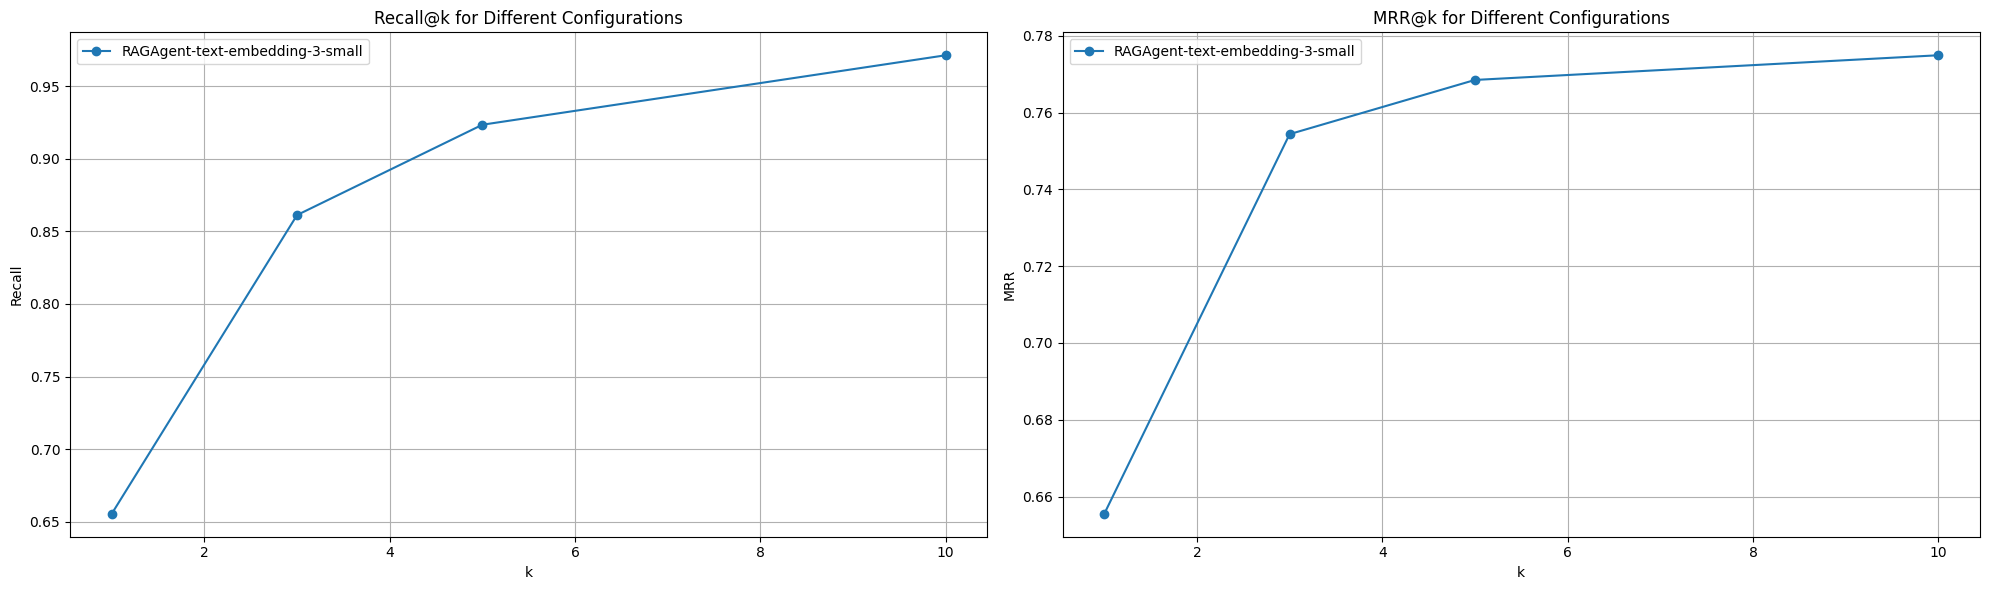

                       config_name  iterations
0  RAGAgent-text-embedding-3-small    1.354067


<Figure size 1200x500 with 0 Axes>

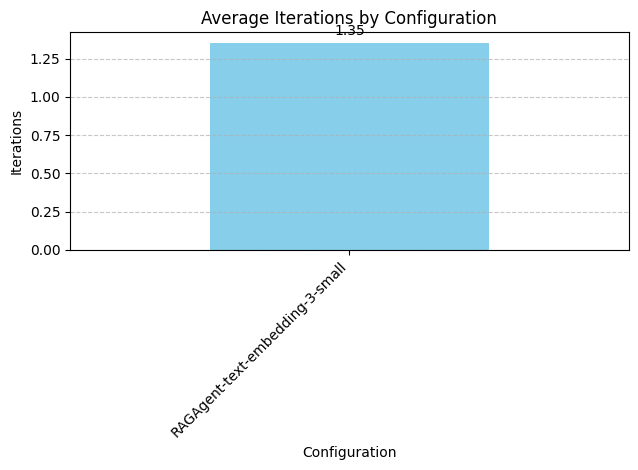

In [25]:
evaluator.visualize_results(evaluation_df)